In [1]:
import matplotlib.pyplot as plt
from util import *
from partition import *
from group_testing import *
from origami_assays import *
from epidemics import *
from networkx.generators.community import gaussian_random_partition_graph

In [10]:
#TODO: Set these paths
data_folder = ""
figures_folder = ""

# Karate network

In [3]:
gamma = .2   #Recovery rate
tau = 1.   #Transmission rate
num_init = 1
max_group_size = 64
perc_infec = .04
trials = 1000
n_samples = 1000
n_trials_origami = 10000
perc_infecs = np.array([.02, .04, .08, .16]) 
sizes = np.arange(2,5) 

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']
origami_assays = [L3, L4, M2, XL3, XL4, XL6]

G = nx.karate_club_graph()

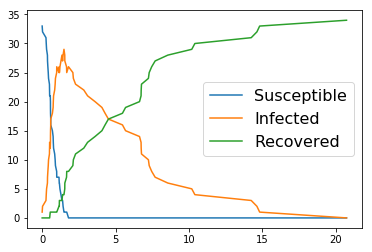

In [4]:
full_data = run_epidemics(G, tau, gamma, None, num_init, 1., True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

In [5]:
avg_perc_inf_karate = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_karate = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight=None)

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_karate[i][n] = best_mean
        std_perc_inf_karate[i][n] = best_std
        i = i + 1
        
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, None)
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_karate[i][n] = best_mean
        std_perc_inf_karate[i][n] = best_std
        i = i + 1
        
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_karate[i][n] = best_mean
        std_perc_inf_karate[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, None)
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_karate[i][n] = best_mean
        std_perc_inf_karate[i][n] = best_std
        i = i + 1

    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_karate[i][n] = best_mean
        std_perc_inf_karate[i][n] = best_std
        i = i + 1
    
    #samp_infec_matrix, samp_node_index = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight=None)
    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight=None)
    
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_karate[i][n] = np.mean(res)
        std_perc_inf_karate[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:        
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_karate[i][n] = np.mean(res)
        std_perc_inf_karate[i][n] = np.std(res)
        i = i + 1
        

In [6]:
for i in range(len(group_approaches)):
    print(group_approaches[i], " ", avg_perc_inf_karate[i])

Rand   [0.37811765 0.47635294 0.57382353 0.76732353]
Mod   [0.37847059 0.482      0.53305882 0.73255882]
Orig   [0.21884498 0.37209302 0.55882353 1.00869565]
Top-Greedy   [0.37947059 0.46358824 0.53458824 0.71647059]
Top-KL   [0.37947059 0.46358824 0.53458824 0.71647059]
Samp-Greedy   [0.35029412 0.42505882 0.50011765 0.68176471]
Samp-KL   [0.34773529 0.41017647 0.49414706 0.67708824]


# Primary school

In [15]:
gamma = 1.5   #Recovery rate
tau = 40.   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32])
perc_infec = .04
sizes = np.arange(2,16)
max_group_size = 64
group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']

origami_assays = [L3, L4, M2, XL3, XL4, XL6]

#Primary school
G = read_contact_net(data_folder+"primaryschool.csv", 20, '\t')

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  242
#edges =  2242


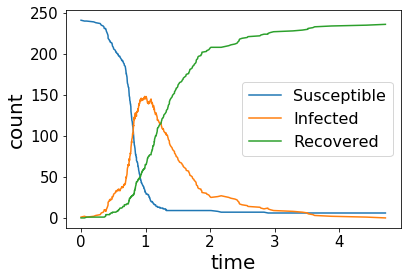

In [13]:
full_data = run_epidemics(G, tau, gamma, 'weight', num_init, perc_infec, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_primary.pdf", bbox_inches='tight', format='pdf')

In [16]:
avg_perc_inf_primary = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_primary = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight='weight')

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_primary[i][n] = best_mean
        std_perc_inf_primary[i][n] = best_std
        i = i + 1
        
    #print("best size random = ", best_size)
        
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight='weight')
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_primary[i][n] = best_mean
        std_perc_inf_primary[i][n] = best_std
        i = i + 1
    
    #print("best size modularity = ", best_size)
        
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_primary[i][n] = best_mean
        std_perc_inf_primary[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight='weight')
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_primary[i][n] = best_mean
        std_perc_inf_primary[i][n] = best_std
        i = i + 1

    #print("best size greedy = ", best_size)

    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            #print("size = ", size)
            top_kl =  topol_kernighan_lin(G, size, weight='weight', n_iter=2)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_primary[i][n] = best_mean
        std_perc_inf_primary[i][n] = best_std
        i = i + 1
   
    #print("best size KL = ", best_size)

    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight='weight')
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_primary[i][n] = np.mean(res)
        std_perc_inf_primary[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_primary[i][n] = np.mean(res)
        std_perc_inf_primary[i][n] = np.std(res)
        
        i = i + 1

In [17]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_primary[i][p], "+/-", std_perc_inf_primary[i][p])

Rand   0.02   0.2817355371900827 +/- 0.013113048938192557
Mod   0.02   0.23657727272727266 +/- 0.038402982569690255
Orig   0.02   0.1732522796352583 +/- 5.551115123125783e-17
Top-Greedy   0.02   0.21227603305785123 +/- 0.04494851826753694
Top-KL   0.02   0.21157024793388426 +/- 0.044720901368293986
Samp-Greedy   0.02   0.2201376033057851 +/- 0.04211917757623133
Samp-KL   0.02   0.21060123966942146 +/- 0.03740171870497295
Rand   0.04   0.3917863636363636 +/- 0.016356157355679673
Mod   0.04   0.3202363636363636 +/- 0.04648431432993425
Orig   0.04   0.3221884498480243 +/- 0.0
Top-Greedy   0.04   0.28337892561983474 +/- 0.04420339750401729
Top-KL   0.04   0.2830235537190083 +/- 0.04402910132366987
Samp-Greedy   0.04   0.28143099173553715 +/- 0.04815377752973458
Samp-KL   0.04   0.2744429752066116 +/- 0.0453980131094964
Rand   0.08   0.5435677685950413 +/- 0.021411944215757137
Mod   0.08   0.4369863636363638 +/- 0.05716573633685694
Orig   0.08   0.5036764705882354 +/- 1.1102230246251565e-16

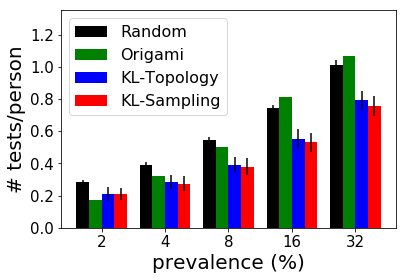

In [18]:
plt.figure()

width = .2


plt.bar(np.arange(avg_perc_inf_primary.shape[1])-1.5*width, avg_perc_inf_primary[0], width, yerr=std_perc_inf_primary[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_primary.shape[1])-0.5*width, avg_perc_inf_primary[2], width, yerr=std_perc_inf_primary[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_primary.shape[1])+0.5*width, avg_perc_inf_primary[4], width, yerr=std_perc_inf_primary[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_primary.shape[1])+1.5*width, avg_perc_inf_primary[6], width, yerr=std_perc_inf_primary[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_primary.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_primary_school.pdf", bbox_inches='tight', format='pdf')

# High School

In [19]:
gamma = .2   #Recovery rate
tau = 40.   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32]) 
sizes = np.arange(2,16)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']
origami_assays = [L3, L4, M2, XL3, XL4, XL6]

#High school
G = read_contact_net(data_folder+"High-School_data_2013.csv", 20)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  327
#edges =  2141


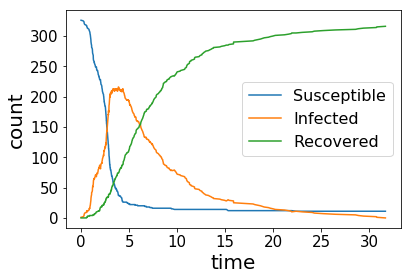

In [20]:
full_data = run_epidemics(G, tau, gamma, 'weight', num_init, .32, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_high_school.pdf", bbox_inches='tight', format='pdf')

In [21]:
avg_perc_inf_high = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_high = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight='weight')

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_high[i][n] = best_mean
        std_perc_inf_high[i][n] = best_std
        i = i + 1
        
    #print("best size random = ", best_size)
    
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight='weight')
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_high[i][n] = best_mean
        std_perc_inf_high[i][n] = best_std
        i = i + 1
    
    #print("best size modularity = ", best_size)
        
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_high[i][n] = best_mean
        std_perc_inf_high[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight='weight')
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_high[i][n] = best_mean
        std_perc_inf_high[i][n] = best_std
        i = i + 1

    #print("best size greedy = ", best_size)

    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight='weight',  n_iter=2)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_high[i][n] = best_mean
        std_perc_inf_high[i][n] = best_std
        i = i + 1
    
    #print("best size KL = ", best_size)
    
    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight='weight')
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_high[i][n] = np.mean(res)
        std_perc_inf_high[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_high[i][n] = np.mean(res)
        std_perc_inf_high[i][n] = np.std(res)
        
        i = i + 1

In [22]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_high[i][p], "+/-", std_perc_inf_high[i][p])

Rand   0.02   0.2850767584097859 +/- 0.012081816057642907
Mod   0.02   0.210288379204893 +/- 0.037541529717561965
Orig   0.02   0.18237082066869303 +/- 2.7755575615628914e-17
Top-Greedy   0.02   0.1786311926605505 +/- 0.03680655563562964
Top-KL   0.02   0.1786311926605505 +/- 0.03680655563562964
Samp-Greedy   0.02   0.18030183486238535 +/- 0.044698015396702116
Samp-KL   0.02   0.1732474006116208 +/- 0.03948723117066261
Rand   0.04   0.39793180428134556 +/- 0.014423750362882851
Mod   0.04   0.268140366972477 +/- 0.04058532737201869
Orig   0.04   0.3191489361702127 +/- 5.551115123125783e-17
Top-Greedy   0.04   0.23461192660550464 +/- 0.047339018124412116
Top-KL   0.04   0.23461192660550464 +/- 0.047339018124412116
Samp-Greedy   0.04   0.2260357798165138 +/- 0.05160974745815553
Samp-KL   0.04   0.22164159021406732 +/- 0.04899976455424765
Rand   0.08   0.544700611620795 +/- 0.01603869491834551
Mod   0.08   0.3564675840978594 +/- 0.055951001137051724
Orig   0.08   0.4883720930232558 +/- 0.0

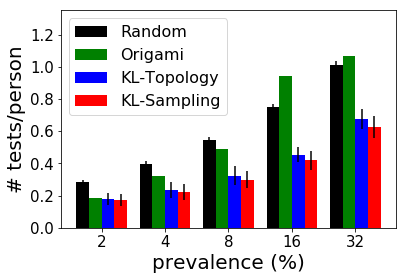

In [24]:
plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_high.shape[1])-1.5*width, avg_perc_inf_high[0], width, yerr=std_perc_inf_high[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_high.shape[1])-0.5*width, avg_perc_inf_high[2], width, yerr=std_perc_inf_high[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_high.shape[1])+0.5*width, avg_perc_inf_high[4], width, yerr=std_perc_inf_high[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_high.shape[1])+1.5*width, avg_perc_inf_high[6], width, yerr=std_perc_inf_high[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_high.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_high_school.pdf", bbox_inches='tight', format='pdf')

# Company

In [25]:
gamma = 1.   #Recovery rate
tau = 40.   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32]) 
sizes = np.arange(2,16)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']
origami_assays = [L3, L4, M2, XL3, XL4, XL6]

#Company
G = read_contact_net(data_folder+"tij_InVS15.dat_", 20)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  217
#edges =  1428


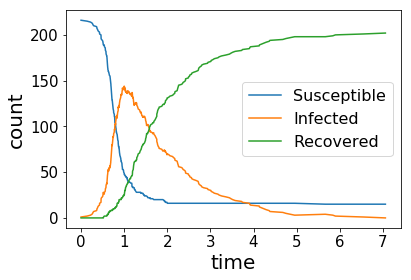

In [26]:
full_data = run_epidemics(G, tau, gamma, 'weight', num_init, .04, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_company.pdf", bbox_inches='tight', format='pdf')

In [27]:
avg_perc_inf_company = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_company = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight='weight')

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_company[i][n] = best_mean
        std_perc_inf_company[i][n] = best_std
        i = i + 1
    
    #print("best size random = ", best_size)
    
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight='weight')
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_company[i][n] = best_mean
        std_perc_inf_company[i][n] = best_std
        i = i + 1
    
    #print("best size modularity = ", best_size)
    
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_company[i][n] = best_mean
        std_perc_inf_company[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight='weight')
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_company[i][n] = best_mean
        std_perc_inf_company[i][n] = best_std
        i = i + 1
        
    #print("best size greedy = ", best_size)
        
    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight='weight', n_iter=2)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_company[i][n] = best_mean
        std_perc_inf_company[i][n] = best_std
        i = i + 1
    
    #print("best size KL = ", best_size)
    
    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight='weight')
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_company[i][n] = np.mean(res)
        std_perc_inf_company[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_company[i][n] = np.mean(res)
        std_perc_inf_company[i][n] = np.std(res)
        
        i = i + 1

In [28]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_company[i][p], "+/-", std_perc_inf_company[i][p])

Rand   0.02   0.2951635944700461 +/- 0.015655558567099007
Mod   0.02   0.24668018433179717 +/- 0.04349862415115188
Orig   0.02   0.18681318681318687 +/- 5.551115123125783e-17
Top-Greedy   0.02   0.22296405529953917 +/- 0.04457428097279114
Top-KL   0.02   0.2221797235023041 +/- 0.04015346524125499
Samp-Greedy   0.02   0.22842718894009217 +/- 0.041017987752801896
Samp-KL   0.02   0.21891105990783408 +/- 0.03841775660821275
Rand   0.04   0.39562764976958514 +/- 0.016004428871627265
Mod   0.04   0.3225695852534562 +/- 0.05989553121456235
Orig   0.04   0.2913043478260869 +/- 5.551115123125783e-17
Top-Greedy   0.04   0.28789953917050687 +/- 0.04613520869997015
Top-KL   0.04   0.28759999999999997 +/- 0.051702924160967854
Samp-Greedy   0.04   0.2878216589861751 +/- 0.04890019304224143
Samp-KL   0.04   0.2773921658986175 +/- 0.045968157763500384
Rand   0.08   0.5457465437788018 +/- 0.02123992628922943
Mod   0.08   0.4567004608294931 +/- 0.04190741553192766
Orig   0.08   0.46511627906976744 +/- 

<Figure size 432x288 with 0 Axes>

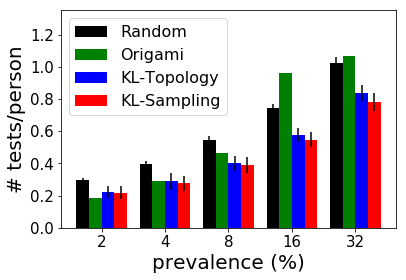

In [30]:
plt.clf()

plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_company.shape[1])-1.5*width, avg_perc_inf_company[0], width, yerr=std_perc_inf_company[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_company.shape[1])-0.5*width, avg_perc_inf_company[2], width, yerr=std_perc_inf_company[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_company.shape[1])+0.5*width, avg_perc_inf_company[4], width, yerr=std_perc_inf_company[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_company.shape[1])+1.5*width, avg_perc_inf_company[6], width, yerr=std_perc_inf_company[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_company.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_company.pdf", bbox_inches='tight', format='pdf')

# Conference

In [31]:
gamma = .2   #Recovery rate
tau = 40.   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32]) 
sizes = np.arange(2,64)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']
origami_assays = [L3, L4, M2, XL3, XL4, XL6]

#Conference
G = read_contact_net(data_folder+"tij_SFHH.dat_", 20)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  403
#edges =  2334


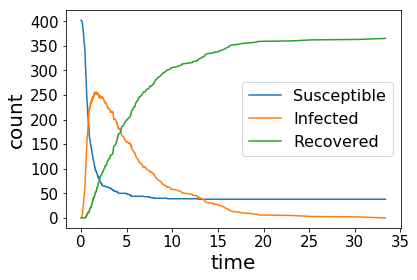

In [32]:
full_data = run_epidemics(G, tau, gamma, 'weight', num_init, .04, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_conference.pdf", bbox_inches='tight', format='pdf')

In [33]:
avg_perc_inf_conference = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_conference = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight='weight')

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_conference[i][n] = best_mean
        std_perc_inf_conference[i][n] = best_std
        i = i + 1
    
#    print("best size random = ", best_size)
    
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight='weight')
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_conference[i][n] = best_mean
        std_perc_inf_conference[i][n] = best_std
        i = i + 1
    
#    print("best size modularity = ", best_size)
        
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_conference[i][n] = best_mean
        std_perc_inf_conference[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight='weight')
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_conference[i][n] = best_mean
        std_perc_inf_conference[i][n] = best_std
        i = i + 1

#    print("best size greedy = ", best_size)
    
    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight='weight', n_iter=2)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
            
        avg_perc_inf_conference[i][n] = best_mean
        std_perc_inf_conference[i][n] = best_std
        i = i + 1
        
#    print("best size KL = ", best_size)
    
    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight='weight')
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_conference[i][n] = np.mean(res)
        std_perc_inf_conference[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_conference[i][n] = np.mean(res)
        std_perc_inf_conference[i][n] = np.std(res)
        
        i = i + 1

In [34]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_conference[i][p], "+/-", std_perc_inf_conference[i][p])

Rand   0.02   0.2918 +/- 0.011010297408142819
Mod   0.02   0.2395111662531017 +/- 0.03373288927957333
Orig   0.02   0.18995290423861852 +/- 0.0
Top-Greedy   0.02   0.21428436724565758 +/- 0.03404436084549682
Top-KL   0.02   0.2138367245657568 +/- 0.033888564999487815
Samp-Greedy   0.02   0.21756203473945412 +/- 0.03222975411171955
Samp-KL   0.02   0.21069578163771713 +/- 0.03149386572022689
Rand   0.04   0.39459057071960296 +/- 0.016949398477531023
Mod   0.04   0.32714441687344914 +/- 0.039516917331869406
Orig   0.04   0.3488333333333334 +/- 0.0003875775188953249
Top-Greedy   0.04   0.2956995037220843 +/- 0.031480692836276865
Top-KL   0.04   0.2949233250620348 +/- 0.0315438605088078
Samp-Greedy   0.04   0.29123672456575683 +/- 0.03896599315495123
Samp-KL   0.04   0.28242928039702236 +/- 0.03643391785463242
Rand   0.08   0.538379900744417 +/- 0.015823605105040987
Mod   0.08   0.46649081885856086 +/- 0.033857465778851924
Orig   0.08   0.49612403100775193 +/- 0.0
Top-Greedy   0.08   0.419

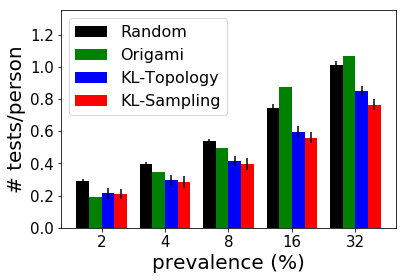

In [35]:
plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_conference.shape[1])-1.5*width, avg_perc_inf_conference[0], width, yerr=std_perc_inf_conference[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_conference.shape[1])-0.5*width, avg_perc_inf_conference[2], width, yerr=std_perc_inf_conference[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_conference.shape[1])+0.5*width, avg_perc_inf_conference[4], width, yerr=std_perc_inf_conference[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_conference.shape[1])+1.5*width, avg_perc_inf_conference[6], width, yerr=std_perc_inf_conference[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_conference.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_conference.pdf", bbox_inches='tight', format='pdf')

# ER Graph

In [36]:
gamma = 1.   #Recovery rate
tau = 1.   #Transmission rate
num_init = 4
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32]) 
sizes = np.arange(2,10)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']

origami_assays = [L3, L4, M2, XL3, XL4, XL6]

n = 500
m = 5*n

G = nx.gnm_random_graph(n, m)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  500
#edges =  2500


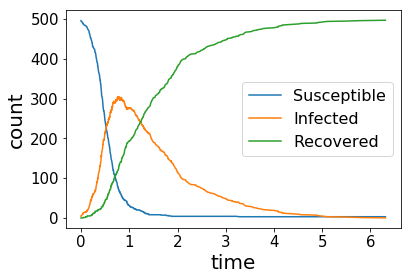

In [37]:
full_data = run_epidemics(G, tau, gamma, None, num_init, .04, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_er.pdf", bbox_inches='tight', format='pdf')

In [39]:
avg_perc_inf_er = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_er = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight=None)

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_er[i][n] = best_mean
        std_perc_inf_er[i][n] = best_std
        i = i + 1
    
#    print("best size, random = ", best_size)
    
    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight=None)
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_er[i][n] = best_mean
        std_perc_inf_er[i][n] = best_std
        i = i + 1
        
#    print("best size, modularity = ", best_size)
         
    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_er[i][n] = best_mean
        std_perc_inf_er[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_er[i][n] = best_mean
        std_perc_inf_er[i][n] = best_std
        i = i + 1
        
#    print("best size, greedy = ", best_size)

    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_er[i][n] = best_mean
        std_perc_inf_er[i][n] = best_std
        i = i + 1
    
#    print("best size, KL = ", best_size)

    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight=None)
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_er[i][n] = np.mean(res)
        std_perc_inf_er[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_er[i][n] = np.mean(res)
        std_perc_inf_er[i][n] = np.std(res)
        
        i = i + 1

In [40]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_er[i][p], "+/-", std_perc_inf_er[i][p])

Rand   0.02   0.275656 +/- 0.011517085742495785
Mod   0.02   0.27037680000000003 +/- 0.013881052617146863
Orig   0.02   0.1732522796352583 +/- 5.551115123125783e-17
Top-Greedy   0.02   0.2600824 +/- 0.01648047360484522
Top-KL   0.02   0.2600824 +/- 0.01648047360484522
Samp-Greedy   0.02   0.26458319999999996 +/- 0.016565381908063576
Samp-KL   0.02   0.2632676 +/- 0.01638334490389554
Rand   0.04   0.38509 +/- 0.010876207978886767
Mod   0.04   0.3788768 +/- 0.01572969236062804
Orig   0.04   0.3422291993720564 +/- 1.1102230246251565e-16
Top-Greedy   0.04   0.36043400000000003 +/- 0.01847849680033525
Top-KL   0.04   0.36043400000000003 +/- 0.01847849680033525
Samp-Greedy   0.04   0.37101880000000004 +/- 0.0239238886170288
Samp-KL   0.04   0.3642608 +/- 0.022748063288113123
Rand   0.08   0.5336736000000002 +/- 0.014062114458359396
Mod   0.08   0.5284200000000001 +/- 0.014796526619446889
Orig   0.08   0.43410852713178283 +/- 1.1102230246251565e-16
Top-Greedy   0.08   0.504242 +/- 0.021826255

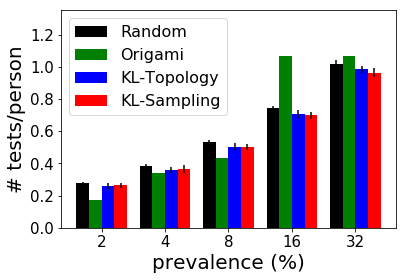

In [41]:
plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_er.shape[1])-1.5*width, avg_perc_inf_er[0], width, yerr=std_perc_inf_er[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_er.shape[1])-0.5*width, avg_perc_inf_er[2], width, yerr=std_perc_inf_er[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_er.shape[1])+0.5*width, avg_perc_inf_er[4], width, yerr=std_perc_inf_er[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_er.shape[1])+1.5*width, avg_perc_inf_er[6], width, yerr=std_perc_inf_er[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_er.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_er.pdf", bbox_inches='tight')

# Gaussian Random Partition

In [42]:
gamma = .1   #Recovery rate
tau = .1   #Transmission rate
num_init = 1
trials = 10000
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16, .32])
sizes = np.arange(2,15)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']

origami_assays = [L3, L4, M2, XL3, XL4, XL6]

G = gaussian_random_partition_graph(400, 10, 10, .8, 0.01)

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  400
#edges =  2158


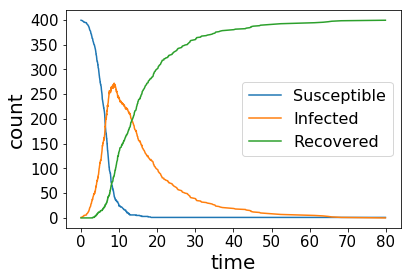

In [43]:
full_data = run_epidemics(G, tau, gamma, None, num_init, .04, True)

plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_sbm.pdf", bbox_inches='tight', format='pdf')

In [44]:
avg_perc_inf_sbm = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_sbm = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight=None)

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_sbm[i][n] = best_mean
        std_perc_inf_sbm[i][n] = best_std
        i = i + 1
    
#    print("best size, random = ", best_size)

    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G, weight=None)
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_sbm[i][n] = best_mean
        std_perc_inf_sbm[i][n] = best_std
        i = i + 1

#    print("best size, modularity = ", best_size)

    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_sbm[i][n] = best_mean
        std_perc_inf_sbm[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G, size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_sbm[i][n] = best_mean
        std_perc_inf_sbm[i][n] = best_std
        i = i + 1

#    print("best size, greedy = ", best_size)
    
    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G, size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_sbm[i][n] = best_mean
        std_perc_inf_sbm[i][n] = best_std
        i = i + 1
  
#    print("best size, KL = ", best_size)

    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight=None)
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_sbm[i][n] = np.mean(res)
        std_perc_inf_sbm[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_sbm[i][n] = np.mean(res)
        std_perc_inf_sbm[i][n] = np.std(res)
        
        i = i + 1

In [45]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_sbm[i][p], "+/-", std_perc_inf_sbm[i][p])

Rand   0.02   0.273924 +/- 0.013450733214215483
Mod   0.02   0.20462999999999998 +/- 0.03558262356825309
Orig   0.02   0.16954474097331235 +/- 5.551115123125783e-17
Top-Greedy   0.02   0.19896750000000002 +/- 0.029713152706335295
Top-KL   0.02   0.19896750000000002 +/- 0.029713152706335295
Samp-Greedy   0.02   0.1984275 +/- 0.03433469082065543
Samp-KL   0.02   0.191681 +/- 0.032291531227242855
Rand   0.04   0.38462050000000003 +/- 0.015851056108348114
Mod   0.04   0.29022749999999997 +/- 0.03817146504589521
Orig   0.04   0.34850863422291994 +/- 0.0
Top-Greedy   0.04   0.281773 +/- 0.03393177303059774
Top-KL   0.04   0.281773 +/- 0.03393177303059774
Samp-Greedy   0.04   0.2746355 +/- 0.03629426111315672
Samp-KL   0.04   0.26566625 +/- 0.03503063639070093
Rand   0.08   0.533539 +/- 0.015828628462377918
Mod   0.08   0.42915699999999996 +/- 0.03144653162115021
Orig   0.08   0.49612403100775193 +/- 0.0
Top-Greedy   0.08   0.418228 +/- 0.0388347784337699
Top-KL   0.08   0.418228 +/- 0.038834

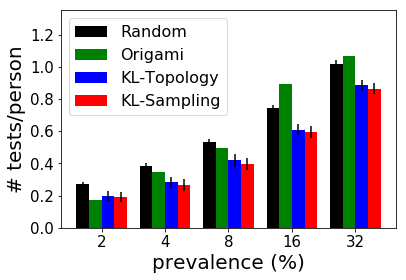

In [46]:
plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_sbm.shape[1])-1.5*width, avg_perc_inf_sbm[0], width, yerr=std_perc_inf_sbm[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_sbm.shape[1])-0.5*width, avg_perc_inf_sbm[2], width, yerr=std_perc_inf_sbm[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_sbm.shape[1])+0.5*width, avg_perc_inf_sbm[4], width, yerr=std_perc_inf_sbm[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_sbm.shape[1])+1.5*width, avg_perc_inf_sbm[6], width, yerr=std_perc_inf_sbm[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(avg_perc_inf_sbm.shape[1]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_sbm.pdf", bbox_inches='tight')

# Gowalla

In [54]:
G = nx.read_edgelist(data_folder+"gowalla_net_cc.csv",  create_using=nx.DiGraph())

gamma = 1.   #Recovery rate
tau = 10.   #Transmission rate
num_init = 5
trials = 100
n_samples = 1000
n_trials_origami = 10000

perc_infecs = np.array([.02, .04, .08, .16])
sizes = np.arange(4,15)
max_group_size = 64

group_approaches = ['Rand', 'Mod', 'Orig', 'Top-Greedy', 'Top-KL', 'Samp-Greedy', 'Samp-KL']

origami_assays = [L3, L4, M2, XL3, XL4, XL6]

print("#nodes = ", G.number_of_nodes())
print("#edges = ", G.number_of_edges())

#nodes =  1899
#edges =  3565


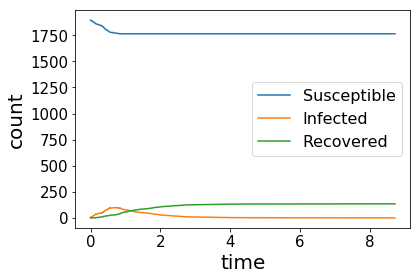

In [55]:
full_data = run_epidemics(G, tau, gamma, None, num_init, .04, True)

plt.clf()
plt.plot(full_data.t(), full_data.S(), label="Susceptible")
plt.plot(full_data.t(), full_data.I(), label="Infected")
plt.plot(full_data.t(), full_data.R(), label="Recovered")
plt.legend(loc='center right', fontsize=16, ncol=1)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("time", fontsize=20)
plt.ylabel("count", fontsize=20)

plt.savefig(figures_folder+"sir_gowalla.pdf", bbox_inches='tight', format='pdf')

In [56]:
avg_perc_inf_gowalla = np.zeros((len(group_approaches), perc_infecs.shape[0]))
std_perc_inf_gowalla = np.zeros((len(group_approaches), perc_infecs.shape[0]))

for n in range(perc_infecs.shape[0]):    
    infec_matrix = sample_epidemics(G, tau, gamma, trials, perc_infecs[n], num_init, weight=None)

    i = 0
    #Random
    if 'Rand' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            rand_groups = random_groups(G, size)
            res = evaluate_two_level_group_testing(infec_matrix, rand_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_gowalla[i][n] = best_mean
        std_perc_inf_gowalla[i][n] = best_std
        i = i + 1
    
#    print("best size, random = ", best_size)

    #Modularity
    if 'Mod' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            mod_clusters = modularity_min(G.to_undirected(), weight=None)
            mod_groups = cluster_groups(mod_clusters, size)
            res = evaluate_two_level_group_testing(infec_matrix, mod_groups)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_gowalla[i][n] = best_mean
        std_perc_inf_gowalla[i][n] = best_std
        i = i + 1

#    print("best size, modularity = ", best_size)

    #Origami
    if 'Orig' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(len(origami_assays)):
            res = evaluate_origami_assay(np.mean(infec_matrix), origami_assays[s], n_trials_origami)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
        
        avg_perc_inf_gowalla[i][n] = best_mean
        std_perc_inf_gowalla[i][n] = best_std
        i = i + 1    
        
    #Greedy group topology
    if 'Top-Greedy' in group_approaches:
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_gr = topol_greedy_group(G.to_undirected(), size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_gr)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_gowalla[i][n] = best_mean
        std_perc_inf_gowalla[i][n] = best_std
        i = i + 1

#    print("best size, greedy = ", best_size)
    
    #Kernighan-Lin topology
    if 'Top-KL' in group_approaches:        
        best_mean = 100 * G.number_of_nodes()
        
        for s in range(sizes.shape[0]):
            size = sizes[s]
            top_kl =  topol_kernighan_lin(G.to_undirected(), size, weight=None)
            res = evaluate_two_level_group_testing(infec_matrix, top_kl)
            
            if np.mean(res) < best_mean:
                best_mean = np.mean(res)
                best_std = np.std(res)
                best_size = size
            
        avg_perc_inf_gowalla[i][n] = best_mean
        std_perc_inf_gowalla[i][n] = best_std
        i = i + 1
  
#    print("best size, KL = ", best_size)

    samp_infec_matrix = sample_epidemics(G, tau, gamma, n_samples, perc_infecs[n], num_init, weight=None)
    
    #Greedy group sampling
    if 'Samp-Greedy' in group_approaches:
        samp_gr = samp_greedy_group(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_gr)
        
        avg_perc_inf_gowalla[i][n] = np.mean(res)
        std_perc_inf_gowalla[i][n] = np.std(res)
        
        i = i + 1
    
    #Kernighan-Lin sampling
    if 'Samp-KL' in group_approaches:
        samp_kl = samp_kernighan_lin(G, max_group_size, samp_infec_matrix)
        res = evaluate_two_level_group_testing(infec_matrix, samp_kl)
        
        avg_perc_inf_gowalla[i][n] = np.mean(res)
        std_perc_inf_gowalla[i][n] = np.std(res)
        
        i = i + 1

In [57]:
for p in range(perc_infecs.shape[0]):
    for i in range(len(group_approaches)):
        print(group_approaches[i], " ", perc_infecs[p], " ", avg_perc_inf_gowalla[i][p], "+/-", std_perc_inf_gowalla[i][p])

Rand   0.02   0.27484465508162187 +/- 0.005011911796179329
Mod   0.02   0.2493522906793049 +/- 0.01119861027568533
Orig   0.02   0.1762917933130699 +/- 0.0
Top-Greedy   0.02   0.2283728278041074 +/- 0.012215113078436833
Top-KL   0.02   0.2283728278041074 +/- 0.012215113078436833
Samp-Greedy   0.02   0.17844655081621902 +/- 0.024310767081519625
Samp-KL   0.02   0.1749973670352817 +/- 0.02295714294804499
Rand   0.04   0.38083201685097423 +/- 0.00693305158214587
Mod   0.04   0.35278041074249616 +/- 0.015305160065040633
Orig   0.04   0.31003039513677816 +/- 5.551115123125783e-17
Top-Greedy   0.04   0.31966298051606107 +/- 0.012914721735049128
Top-KL   0.04   0.31966298051606107 +/- 0.012914721735049128
Samp-Greedy   0.04   0.21000526592943658 +/- 0.026864705580674626
Samp-KL   0.04   0.20580305423907316 +/- 0.026726797264106428
Rand   0.08   0.5282201158504476 +/- 0.007013417400190757
Mod   0.08   0.49805160610847815 +/- 0.013337675146417325
Orig   0.08   0.4883720930232558 +/- 0.0
Top-Gre

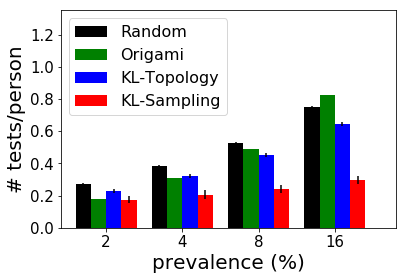

In [58]:
plt.figure()

width = .2

plt.bar(np.arange(avg_perc_inf_gowalla.shape[1])-1.5*width, avg_perc_inf_gowalla[0], width, yerr=std_perc_inf_gowalla[0], color='black', label='Random')
plt.bar(np.arange(avg_perc_inf_gowalla.shape[1])-0.5*width, avg_perc_inf_gowalla[2], width, yerr=std_perc_inf_gowalla[2], color='green', label='Origami')
plt.bar(np.arange(avg_perc_inf_gowalla.shape[1])+0.5*width, avg_perc_inf_gowalla[4], width, yerr=std_perc_inf_gowalla[4], color='blue', label='KL-Topology')
plt.bar(np.arange(avg_perc_inf_gowalla.shape[1])+1.5*width, avg_perc_inf_gowalla[6], width, yerr=std_perc_inf_gowalla[6], color='red', label='KL-Sampling')

plt.xticks(np.arange(perc_infecs.shape[0]), np.array(100*perc_infecs,dtype=int))
plt.xlabel("prevalence (%)", fontsize=20)
plt.ylabel("# tests/person", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.35)
plt.xlim(None,3.8)
plt.legend(loc='upper left', fontsize=16, ncol=1)

plt.savefig(figures_folder+"n_infected_tests_gowalla.pdf", bbox_inches='tight')